In [29]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns


### Loading dataset

In [3]:
stock_market = pd.read_excel('./nvda-stockmarket.xlsx',engine='openpyxl')

In [4]:
stock_market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353 entries, 0 to 352
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Contract Name          353 non-null    object        
 1   Last Trade Date (EDT)  353 non-null    datetime64[ns]
 2   Strike                 353 non-null    float64       
 3   Last Price             353 non-null    float64       
 4   Bid                    353 non-null    float64       
 5   Ask                    353 non-null    float64       
 6   Change                 353 non-null    float64       
 7   % Change               353 non-null    float64       
 8   Volume                 353 non-null    object        
 9   Open Interest          353 non-null    int64         
 10  Implied Volatility     353 non-null    float64       
 11  Option Type            353 non-null    object        
dtypes: datetime64[ns](1), float64(7), int64(1), object(3)
memory usa

In [5]:
new_column_names = {
    '% Change': 'dChange',
    
}

stock_market.rename(columns=new_column_names, inplace=True)



In [6]:
#stock market date time to date time
stock_market['Date'] = stock_market['Last Trade Date (EDT)'].dt.date

In [7]:
stock_market['Time'] = stock_market['Last Trade Date (EDT)'].dt.time

In [8]:
stock_market.head()

,Contract Name,Last Trade Date (EDT),Strike,Last Price,Bid,Ask,Change,dChange,Volume,Open Interest,Implied Volatility,Option Type,Date,Time
0,NVDA240301C00250000,2024-02-27 20:31:00,250.0,540.03,533.55,535.4,0.0,0.0,9,31,6.1533,call,2024-02-27,20:31:00
1,NVDA240301C00260000,2024-02-26 20:59:00,260.0,531.66,523.95,525.4,0.0,0.0,3,12,6.0527,call,2024-02-26,20:59:00
2,NVDA240301C00270000,2024-02-26 20:13:00,270.0,523.00,513.55,515.4,0.0,0.0,28,16,5.7617,call,2024-02-26,20:13:00
3,NVDA240301C00280000,2024-02-22 18:03:00,280.0,495.19,504.00,505.8,0.0,0.0,1,16,5.7690,call,2024-02-22,18:03:00
4,NVDA240301C00290000,2024-02-26 20:02:00,290.0,500.59,494.15,495.7,0.0,0.0,30,2,5.5967,call,2024-02-26,20:02:00


In [9]:
stock_market = stock_market.drop(['Contract Name','Last Trade Date (EDT)'], axis = 1)

In [10]:
stock_market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353 entries, 0 to 352
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Strike              353 non-null    float64
 1   Last Price          353 non-null    float64
 2   Bid                 353 non-null    float64
 3   Ask                 353 non-null    float64
 4   Change              353 non-null    float64
 5   dChange             353 non-null    float64
 6   Volume              353 non-null    object 
 7   Open Interest       353 non-null    int64  
 8   Implied Volatility  353 non-null    float64
 9   Option Type         353 non-null    object 
 10  Date                353 non-null    object 
 11  Time                353 non-null    object 
dtypes: float64(7), int64(1), object(4)
memory usage: 33.2+ KB


In [14]:

# Assuming 'stock_market' is your DataFrame
# Check for missing values
missing_values = stock_market['Volume'].isnull().sum()
if missing_values > 0:
    print(f"There are {missing_values} missing values in the 'Volume' column. Please handle them before proceeding.")
else:
    # Convert to numeric
    stock_market['Volume'] = pd.to_numeric(stock_market['Volume'], errors='coerce')
    
    # Check for non-finite values
    non_finite_values = stock_market['Volume'].isna().sum()
    if non_finite_values > 0:
        print(f"There are {non_finite_values} non-finite values in the 'Volume' column after converting to numeric. Please investigate.")
    else:
        # Drop non-finite values
        stock_market.dropna(subset=['Volume'], inplace=True)
        
        # Convert to integer
        stock_market['Volume'] = stock_market['Volume'].astype(int)

# Print DataFrame information
stock_market.info()



There are 4 missing values in the 'Volume' column. Please handle them before proceeding.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353 entries, 0 to 352
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Strike              353 non-null    float64
 1   Last Price          353 non-null    float64
 2   Bid                 353 non-null    float64
 3   Ask                 353 non-null    float64
 4   Change              353 non-null    float64
 5   dChange             353 non-null    float64
 6   Volume              349 non-null    float64
 7   Open Interest       353 non-null    int64  
 8   Implied Volatility  353 non-null    float64
 9   Option Type         353 non-null    object 
 10  Date                353 non-null    object 
 11  Time                353 non-null    object 
dtypes: float64(8), int64(1), object(3)
memory usage: 33.2+ KB


There are 4-54 nAN values in volume, Let's get rid of these

In [15]:
stock_market['Volume'].isna().sum()

4

In [16]:
stock_market = stock_market.dropna()

In [17]:
stock_market.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349 entries, 0 to 352
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Strike              349 non-null    float64
 1   Last Price          349 non-null    float64
 2   Bid                 349 non-null    float64
 3   Ask                 349 non-null    float64
 4   Change              349 non-null    float64
 5   dChange             349 non-null    float64
 6   Volume              349 non-null    float64
 7   Open Interest       349 non-null    int64  
 8   Implied Volatility  349 non-null    float64
 9   Option Type         349 non-null    object 
 10  Date                349 non-null    object 
 11  Time                349 non-null    object 
dtypes: float64(8), int64(1), object(3)
memory usage: 35.4+ KB


In [63]:
stock_market  = stock_market.sort_values(by=['Date', 'Time'])

#stock_market = stock_market.sort_values(by = 'Time')

In [64]:
stock_market

,Strike,Last Price,Bid,Ask,Change,dChange,Volume,Open Interest,Implied Volatility,Option Type,Date,Time
20,395.0,227.38,392.65,395.05,0.00,0.0000,3.0,3,4.8450,call,2024-01-25,17:15:00
24,415.0,205.07,372.70,375.05,0.00,0.0000,1.0,1,4.5464,call,2024-01-25,17:20:00
8,330.0,282.75,457.60,459.90,0.00,0.0000,2.0,2,5.9258,call,2024-01-26,20:30:00
16,375.0,243.01,409.00,410.55,0.00,0.0000,1.0,1,4.2095,call,2024-01-29,17:20:00
339,1170.0,431.66,379.75,387.45,0.00,0.0000,20.0,0,1.6191,Puts,2024-02-14,20:58:00
...,...,...,...,...,...,...,...,...,...,...,...,...
256,665.0,0.06,0.05,0.07,-0.02,-0.2500,182.0,1762,0.6836,Puts,2024-02-28,17:28:00
284,765.0,3.60,3.30,3.45,-0.60,-0.1429,6715.0,3590,0.3528,Puts,2024-02-28,17:28:00
287,780.0,8.51,8.30,8.45,-0.54,-0.0597,14617.0,4488,0.3444,Puts,2024-02-28,17:28:00
118,840.0,0.56,0.55,0.57,-0.59,-0.5130,2746.0,5627,0.4517,call,2024-02-28,17:28:00


so the governing equation is dependent on V is the price of the option as a function of the underlying asset price S and time  t.


σ is the volatility of the underlying asset.


r is the risk-free interest rate.

# EDA 

### checking for NANs

In [65]:
print(f'Number of calls and Puts : {stock_market["Option Type"].value_counts()}')

Number of calls and Puts : call    180
Puts    169
Name: Option Type, dtype: int64


if buying a call then betting that it will go up
if put then will go down

/home/rhythm/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/rhythm/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


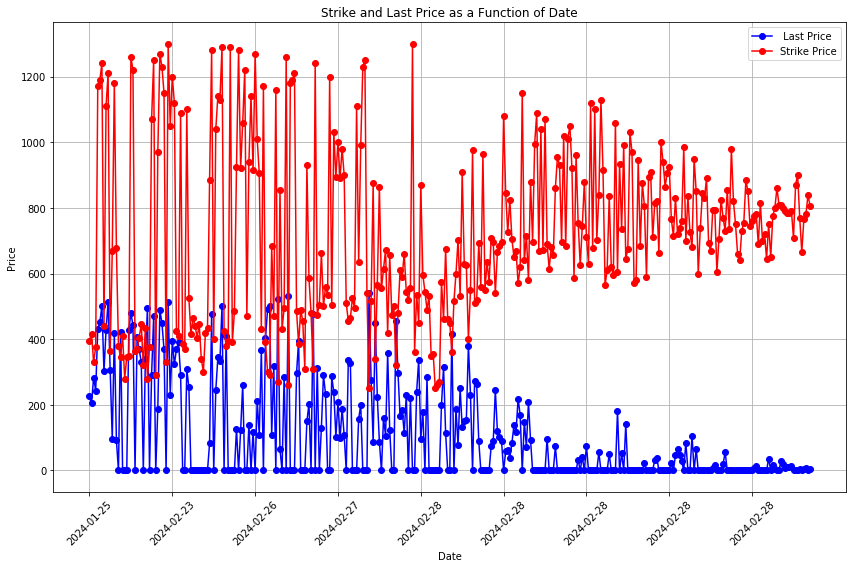

In [66]:
# Plot 'Volume' as a function of 'Date'
plt.figure(figsize=(12, 8))
plt.plot(range(stock_market.shape[0]), stock_market['Last Price'], color = 'blue', marker='o', linestyle='-', label = ' Last Price')
plt.plot(range(stock_market.shape[0]), stock_market['Strike'], color = 'red',marker='o', linestyle='-', label = 'Strike Price')

plt.xticks(range(0,stock_market.shape[0],40),stock_market['Date'].loc[::40],rotation=45)

plt.title('Strike and Last Price as a Function of Date')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

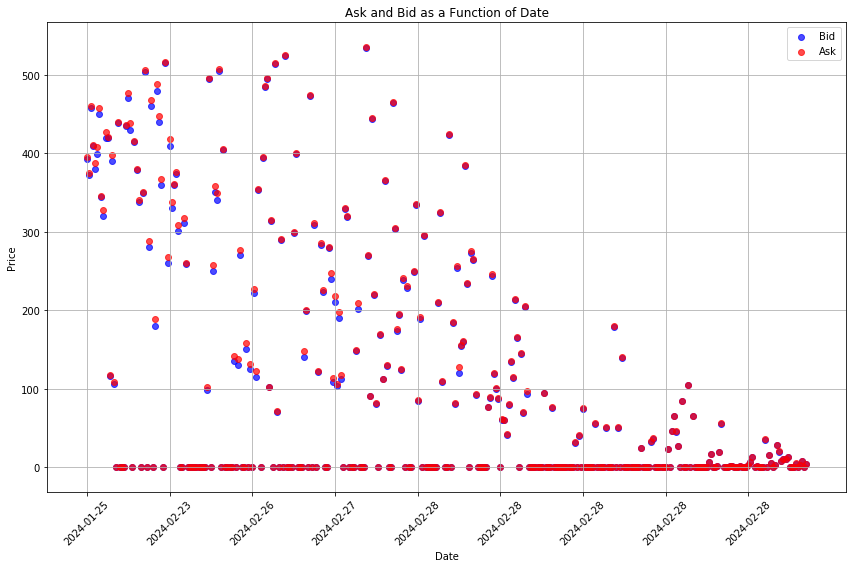

In [67]:
# Plot 'Volume' as a function of 'Date'
plt.figure(figsize=(12, 8))
plt.scatter(range(stock_market.shape[0]), stock_market['Bid'], alpha = 0.7, color = 'blue', marker='o', linestyle='-', label = 'Bid')
plt.scatter(range(stock_market.shape[0]), stock_market['Ask'], alpha = 0.7, color = 'red',marker='o', linestyle='-', label = 'Ask')

plt.xticks(range(0,stock_market.shape[0],40),stock_market['Date'].loc[::40],rotation=45)

plt.title('Ask and Bid as a Function of Date')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

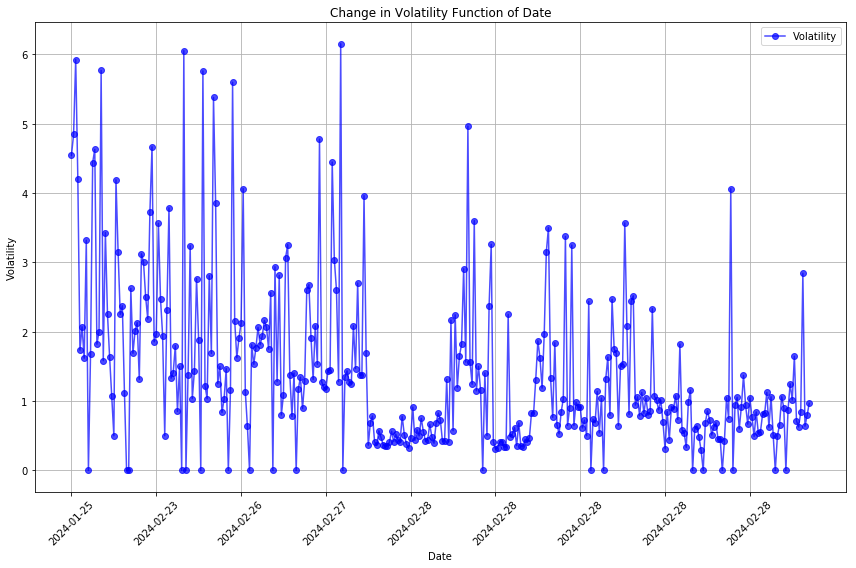

In [61]:
plt.figure(figsize=(12, 8))
plt.plot(range(stock_market.shape[0]), stock_market['Implied Volatility'], alpha = 0.7, color = 'blue', marker='o', linestyle='-', label = 'Volatility')

plt.xticks(range(0,stock_market.shape[0],40),stock_market['Date'].loc[::40],rotation=45)

plt.title('Change in Volatility Function of Date')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
from datetime import datetime

# Convert 'Option Type' to numerical labels
label_encoder = LabelEncoder()

stock_market['Option Type'] = label_encoder.fit_transform(stock_market['Option Type'])

# Separate features and target
y = stock_market['Option Type']
X = stock_market.drop('Option Type', axis = 1)


In [25]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349 entries, 0 to 352
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Strike              349 non-null    float64
 1   Last Price          349 non-null    float64
 2   Bid                 349 non-null    float64
 3   Ask                 349 non-null    float64
 4   Change              349 non-null    float64
 5   dChange             349 non-null    float64
 6   Volume              349 non-null    float64
 7   Open Interest       349 non-null    int64  
 8   Implied Volatility  349 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 27.3 KB


In [16]:
X.shape, y.shape

((349, 9), (349,))

In [14]:
# Turninig Data to Tensor 
X = torch.from_numpy(X.values).type(torch.float)
y = torch.from_numpy(y.values).type(torch.float)

1. input layer shape = # of features
2. Output Layer shape = 1(one class or the other) for multiclassificatin = 3 
3. Hidden Layer Activation usually ReLu could use other too
4. Output activation Sigmoid, Softmax for multiclass
5. Loss Function Binary CrossEntropy
6. Optimizer = SGD, Adan

In [15]:
## Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [71]:
X_train.info()

AttributeError: 'Tensor' object has no attribute 'info'

In [62]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [28]:
# Define the neural network model
class BinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=9, out_features=6) # takes in 11 features (X), produces 6 features
        self.layer_2 = nn.Linear(in_features=6, out_features=1) # takes in 6 features, produces 1 feature (y)
    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        return self.layer_2(self.layer_1(x)) # computation goes through layer_1 first then the output of layer_1 goes through layer_2

# 4. Create an instance of the model and send it to target device
model_0 = BinaryClassifier()
model_0


BinaryClassifier(
  (layer_1): Linear(in_features=9, out_features=6, bias=True)
  (layer_2): Linear(in_features=6, out_features=1, bias=True)
)

In [54]:
# Make predictions with the model
untrained_preds = model_0(X_test)
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 70, Shape: torch.Size([70, 1])
Length of test samples: 70, Shape: torch.Size([70])

First 10 predictions:
tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 0., 0., 1., 0., 0., 0., 0., 0.])


In [19]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=deep.parameters(), 
                            lr=0.001)

In [21]:
# Check for NaN values
has_nan = torch.isnan(X_train).any().item()
if has_nan:
    print("The tensor contains NaN values.")
else:
    print("The tensor does not contain NaN values.")


The tensor does not contain NaN values.


### Training and building 

In [30]:
import torch
import torch.nn as nn
from torch.optim import SGD

torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze()
    # Squeeze to remove extra `1` dimensions; this won't work unless model and data are on the same device 
    y_pred = torch.round(torch.sigmoid(y_logits))  # Turn logits -> pred probs -> pred labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss backward
    loss.backward()
    
    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.no_grad():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        # 2. Calculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
    
    # Print out what's happening every epoch
    print(f"Epoch: {epoch} | Loss: {loss.item():.5f} | Test loss: {test_loss.item():.5f}")

     # Print intermediate values for debugging
    #print("y_pred:", y_pred)
    #print("y_logits:", y_logits)
    #print("test_pred:", test_pred)
    #print("test_logits:", test_logits)

    # Check for NaN or infinite values in tensors
    if torch.isnan(loss) or torch.isinf(loss):
        print("Training loss is NaN or infinite. Exiting training loop.")
        break


Epoch: 0 | Loss: 143.59129 | Test loss: 341.18546
Epoch: 1 | Loss: 242.75963 | Test loss: 29.29285
Epoch: 2 | Loss: 19.02667 | Test loss: 18.66355
Epoch: 3 | Loss: 13.87927 | Test loss: 57.40464
Epoch: 4 | Loss: 35.56451 | Test loss: 11.54196
Epoch: 5 | Loss: 6.53236 | Test loss: 28.11400
Epoch: 6 | Loss: 19.98043 | Test loss: 27.34684
Epoch: 7 | Loss: 17.10603 | Test loss: 2.74864
Epoch: 8 | Loss: 2.06041 | Test loss: 18.74428
Epoch: 9 | Loss: 11.44220 | Test loss: 11.97199
Epoch: 10 | Loss: 7.33447 | Test loss: 2.18331
Epoch: 11 | Loss: 1.85456 | Test loss: 11.59234
Epoch: 12 | Loss: 7.02199 | Test loss: 4.17031
Epoch: 13 | Loss: 2.74874 | Test loss: 15.72265
Epoch: 14 | Loss: 13.79070 | Test loss: 13.57867
Epoch: 15 | Loss: 9.61518 | Test loss: 1.98614
Epoch: 16 | Loss: 2.04755 | Test loss: 13.15585
Epoch: 17 | Loss: 9.90176 | Test loss: 1.32624
Epoch: 18 | Loss: 1.16874 | Test loss: 7.48221
Epoch: 19 | Loss: 6.72798 | Test loss: 7.49547
Epoch: 20 | Loss: 5.62586 | Test loss: 1.6965

Epoch: 21 | Loss: 1.50288 | Test loss: 6.06568
Epoch: 22 | Loss: 4.31421 | Test loss: 3.06850
Epoch: 23 | Loss: 2.46807 | Test loss: 4.21129
Epoch: 24 | Loss: 3.54466 | Test loss: 3.75095
Epoch: 25 | Loss: 3.18610 | Test loss: 5.43813
Epoch: 26 | Loss: 4.43060 | Test loss: 1.05594
Epoch: 27 | Loss: 1.01376 | Test loss: 1.16590
Epoch: 28 | Loss: 0.98542 | Test loss: 1.51749
Epoch: 29 | Loss: 1.10727 | Test loss: 1.46089
Epoch: 30 | Loss: 1.48498 | Test loss: 2.48416
Epoch: 31 | Loss: 2.37024 | Test loss: 4.04444
Epoch: 32 | Loss: 3.27785 | Test loss: 0.72790
Epoch: 33 | Loss: 0.80031 | Test loss: 2.22055
Epoch: 34 | Loss: 1.75533 | Test loss: 1.56449
Epoch: 35 | Loss: 1.58086 | Test loss: 3.21894
Epoch: 36 | Loss: 2.65339 | Test loss: 0.94416
Epoch: 37 | Loss: 0.86329 | Test loss: 1.32623
Epoch: 38 | Loss: 1.26197 | Test loss: 2.19965
Epoch: 39 | Loss: 1.94935 | Test loss: 0.75794
Epoch: 40 | Loss: 0.75120 | Test loss: 0.99759
Epoch: 41 | Loss: 0.95803 | Test loss: 1.65659
Epoch: 42 | L

changing the model and making it denser
2. Plot the losses and. 

In [17]:


class DeeperBinaryClassifier(nn.Module):
    def __init__(self):
        super(DeeperBinaryClassifier, self).__init__()
        self.layer_1 = nn.Linear(in_features=9, out_features=12)
        self.layer_2 = nn.Linear(in_features=12, out_features=8)
        self.layer_3 = nn.Linear(in_features=8, out_features=4)
        self.layer_4 = nn.Linear(in_features=4, out_features=1)

    def forward(self, x):
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        x = F.relu(self.layer_3(x))
        x = self.layer_4(x)
        return x

In [21]:
model = DeeperBinaryClassifier()

Epoch: 0 | Loss: 1.15516 | Test loss: 0.68678
Epoch: 1 | Loss: 0.69333 | Test loss: 0.68678
Epoch: 2 | Loss: 0.69402 | Test loss: 0.68678
Epoch: 3 | Loss: 0.69365 | Test loss: 0.68678
Epoch: 4 | Loss: 0.69385 | Test loss: 0.68679
Epoch: 5 | Loss: 0.69363 | Test loss: 0.68679
Epoch: 6 | Loss: 0.69379 | Test loss: 0.68679
Epoch: 7 | Loss: 0.69359 | Test loss: 0.68679
Epoch: 8 | Loss: 0.69373 | Test loss: 0.68679
Epoch: 9 | Loss: 0.69354 | Test loss: 0.68679
Epoch: 10 | Loss: 0.69368 | Test loss: 0.68679
Epoch: 11 | Loss: 0.69350 | Test loss: 0.68679
Epoch: 12 | Loss: 0.69363 | Test loss: 0.68679
Epoch: 13 | Loss: 0.69347 | Test loss: 0.68680
Epoch: 14 | Loss: 0.69357 | Test loss: 0.68680
Epoch: 15 | Loss: 0.69343 | Test loss: 0.68680
Epoch: 16 | Loss: 0.69352 | Test loss: 0.68680
Epoch: 17 | Loss: 0.69339 | Test loss: 0.68680
Epoch: 18 | Loss: 0.69347 | Test loss: 0.68680
Epoch: 19 | Loss: 0.69335 | Test loss: 0.68680
Epoch: 20 | Loss: 0.69342 | Test loss: 0.68680
Epoch: 21 | Loss: 0.693

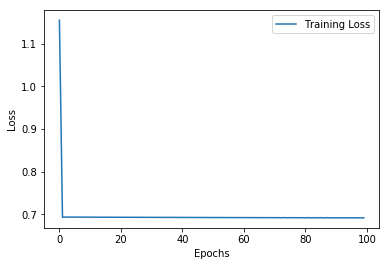

In [20]:
epochs = 100

# Lists to store training loss for plotting
train_loss_history = []

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    deep.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = deep(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))  # Turn logits -> pred probs -> pred labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss backward
    loss.backward()
    
    # 5. Optimizer step
    optimizer.step()

    ### Testing
    deep.eval()
    with torch.no_grad():
        # 1. Forward pass
        test_logits = deep(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        # 2. Calculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
    
    # Print out what's happening every epoch
    print(f"Epoch: {epoch} | Loss: {loss.item():.5f} | Test loss: {test_loss.item():.5f}")

    # Append training loss to the list for plotting
    train_loss_history.append(loss.item())

    # Check for NaN or infinite values in tensors
    if torch.isnan(loss) or torch.isinf(loss):
        print("Training loss is NaN or infinite. Exiting training loop.")
        break

# Plot training loss over epochs
plt.plot(range(epochs), train_loss_history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the number of epochs
epochs = 100

# Training loop
for epoch in range(epochs):
    model.train()
    
    # 1. Forward pass (model outputs raw logits)
    y_logits = model(X_train).squeeze()
    # Squeeze to remove extra `1` dimensions; this won't work unless model and data are on the same device 
    y_pred = torch.round(torch.sigmoid(y_logits))  # Turn logits -> pred probs -> pred labels

    loss = criterion(y_logits, y_train)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print loss for every few epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Evaluate on test data
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)

print(f'Test Loss: {test_loss.item():.4f}')


Epoch [10/100], Loss: 743.2023
Epoch [20/100], Loss: 740.9802
Epoch [30/100], Loss: 740.6160


Epoch [40/100], Loss: 740.2402
Epoch [50/100], Loss: 739.9799
Epoch [60/100], Loss: 739.7703
Epoch [70/100], Loss: 739.5802
Epoch [80/100], Loss: 739.3683
Epoch [90/100], Loss: 739.2172
Epoch [100/100], Loss: 739.0782


RuntimeError: expected scalar type Long but found Float

The differential equation related to the black scholes model is : 
$
    \frac{\delV}{a}
$

In [ ]:
S : Stock Price /  Spot price
K : Strike Price
r : interest rate
sigma : implied volatility

In [1]:
import pandas as pd
df = pd.read_csv("/home/rhythm/Downloads/TSLA.csv")
df = df.sort_values(by="Date")
df = df.dropna()


/home/rhythm/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-03-29,193.130005,195.289993,189.440002,193.880005,193.880005,123660000
1,2023-03-30,195.580002,197.330002,194.419998,195.279999,195.279999,110252200
2,2023-03-31,197.529999,207.789993,197.199997,207.460007,207.460007,170222100
3,2023-04-03,199.910004,202.690002,192.199997,194.770004,194.770004,169545900
4,2023-04-04,197.320007,198.740005,190.320007,192.580002,192.580002,126463800


In [3]:
# calculate returns
df = df.assign(close_day_before=df.Close.shift(1))

In [4]:
df['returns'] = ((df.Close - df.close_day_before)/df.close_day_before)



In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,close_day_before,returns
0,2023-03-29,193.130005,195.289993,189.440002,193.880005,193.880005,123660000,NaN,NaN
1,2023-03-30,195.580002,197.330002,194.419998,195.279999,195.279999,110252200,193.880005,0.007221
2,2023-03-31,197.529999,207.789993,197.199997,207.460007,207.460007,170222100,195.279999,0.062372
3,2023-04-03,199.910004,202.690002,192.199997,194.770004,194.770004,169545900,207.460007,-0.061168
4,2023-04-04,197.320007,198.740005,190.320007,192.580002,192.580002,126463800,194.770004,-0.011244


In [13]:
pip install beautifulsoup4



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [14]:
from bs4 import BeautifulSoup
import requests
import pandas as pd


In [15]:
url = "https://finance.yahoo.com/quote/TSLA/options"
response = requests.get(url)


In [16]:
soup = BeautifulSoup(response.text, 'html.parser')


In [17]:
table = soup.find('table', class_='calls')


In [26]:
pip install requests



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [29]:
import requests

url = 'https://finance.yahoo.com/quote/TSLA/options'

In [32]:
response = requests.get(url)



In [37]:
print(response.status_code)


404


In [35]:
import json
try:
    data = response.json()
#except json.decoder.JSONDecodeError as e:
#    print("Error decoding JSON:", e)
#    print("Response content:", response.text)


SyntaxError: unexpected EOF while parsing (<ipython-input-35-e9e037596af3>, line 6)

the black-scholes modes can estimate the value of "s".  which takes in S :spot price at the moment, for call one can compare the "ask". This would also depend on the volume. [if it has been traded or not]

# Notes

We have black scholes model that can help us predict the call or put options' price. 
The black scholes model is governed by the differential equation :  

$\begin{equation}
    \frac{\partial C}{\partial t} + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 C}{\partial S^2} + rS \frac{\partial C}{\partial S} - rC = 0
\end{equation}    $


where C is the call option price, 
<br> S : Stock price, 
<br> t : at time 't'
<br> r : risk free interest
<br> C : 
<br> $\sigma$ : volatility
<br> C(T,s) : K(s)

we could also use the black scoles model equation too or it can be solved to 


$\begin{equation}
    C = S_0 N(d_1)- K e^{-rT} N(d_2)
\end{equation}    $


where $N(d_1)$ is the cumulative distribution and, is equal to 


$ \begin{equation}
    d_1 = \frac{\ln\left(\frac{S_0}{K}\right) + \left(r + \frac{\sigma^2}{2}\right)T}{\sigma \sqrt{T}}
\end{equation}
$

$ \begin{equation}
    d_2 = d_1 - \sigma \sqrt{T}
\end{equation}
$

$K$ is the strike price , 
$T$ is the time to maturity, $S_0$ is the stock price

We will use this to constrain the loss from PINN
<br>and, also use features to learn from neural network

using yfinance

In [38]:
pip install yfinance


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 5.5 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.9/147.9 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 11.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.5/505.5 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 2.5 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.1-py3-none-any.whl size=136905 sha256=0425ccecefe6559443b0cefbb9a1bb5f3ae2081ea47f00cf10431580ad4c7f6d
  Stored in directory: /home/rhythm/.cache/pip/wheels/c1/c6/

In [3]:
import yfinance as yf

# Define the ticker symbol of the stock you're interested in
ticker_symbol = 'NVDA'

# Fetch historical stock data


In [4]:
stock_data = yf.download(ticker_symbol, start='2024-01-01', end='2024-03-31')



[*********************100%%**********************]  1 of 1 completed


In [13]:
print("Historical Stock Data:")
#print(stock_data.head())
# Convert historical stock data to DataFrame
stock_df = pd.DataFrame(stock_data)
stock_df.head()

Historical Stock Data:


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-01-02,492.440002,492.950012,475.950012,481.679993,481.657410,41125400
2024-01-03,474.850006,481.839996,473.200012,475.690002,475.667694,32089600
2024-01-04,477.670013,485.000000,475.079987,479.980011,479.957489,30653500
2024-01-05,484.619995,495.470001,483.059998,490.970001,490.946960,41456800
2024-01-08,495.119995,522.750000,494.790009,522.530029,522.505493,64251000


In [21]:
#let us look at what the stock_data for nvda is showing 
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61 entries, 2024-01-02 to 2024-03-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       61 non-null     float64
 1   High       61 non-null     float64
 2   Low        61 non-null     float64
 3   Close      61 non-null     float64
 4   Adj Close  61 non-null     float64
 5   Volume     61 non-null     int64  
dtypes: float64(5), int64(1)
memory usage: 3.3 KB


In [22]:
stock_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,61.000000,61.000000,61.000000,61.000000,61.000000,6.100000e+01
mean,722.967538,736.716392,709.355572,724.803769,724.782240,5.395694e+07
std,146.237056,149.848098,140.149338,143.920324,143.929131,1.475191e+07
min,474.850006,481.839996,473.200012,475.690002,475.667694,2.946540e+07
25%,603.039978,617.830017,599.380005,610.309998,610.281372,4.366370e+07
50%,719.469971,734.500000,702.119995,721.330017,721.296204,5.072890e+07
75%,867.000000,895.460022,850.099976,875.280029,875.280029,6.156160e+07
max,958.510010,974.000000,935.099976,950.020020,950.020020,1.132996e+08


In [25]:
#check for duplicated 
stock_df.duplicated().sum()
stock_df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

/home/rhythm/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/rhythm/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/rhythm/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/rhythm/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, Non

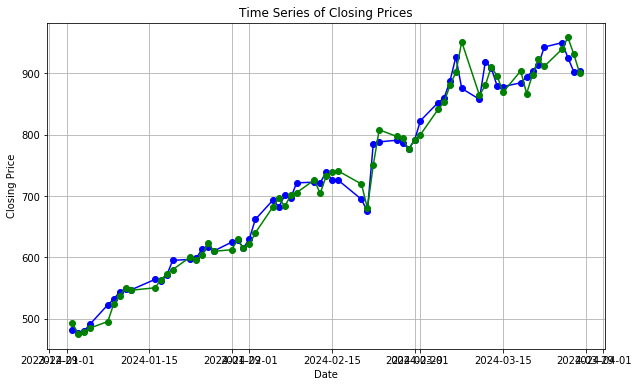

In [28]:
import matplotlib.pyplot as plt

# Plotting the time series of closing prices
plt.figure(figsize=(10, 6))
plt.plot(stock_df.index, stock_df['Close'], color='blue', marker='o', linestyle='-')
plt.plot(stock_df.index, stock_df['Open'], color='green', marker='o', linestyle='-')

# Adding title and labels
plt.title('Time Series of Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')

# Displaying the plot
plt.grid(True)
plt.show()


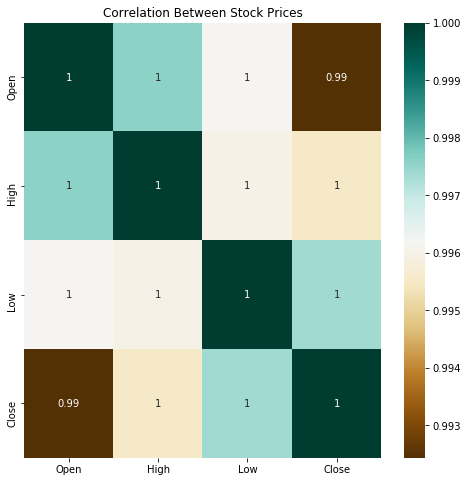

In [33]:
# Create a heatmap of the correlation between stock prices
corr = stock_df[['Open', 'High', 'Low', 'Close']].corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr, annot=True, cmap='BrBG')
plt.title('Correlation Between Stock Prices')
plt.show()

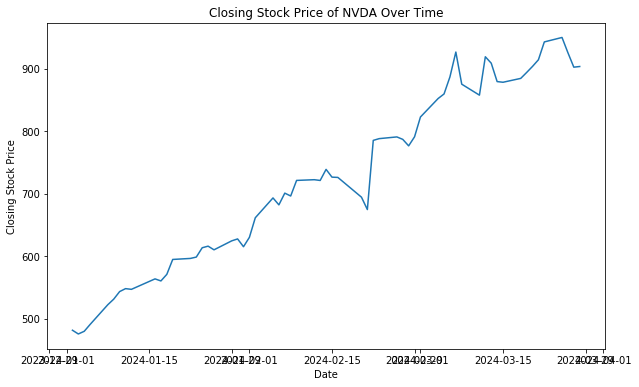

In [34]:

# Line chart of closing stock price for a specific company over time

plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Close', data=stock_df)
plt.title(f'Closing Stock Price of NVDA Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Stock Price')
plt.show()

/home/rhythm/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/rhythm/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/rhythm/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/home/rhythm/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `

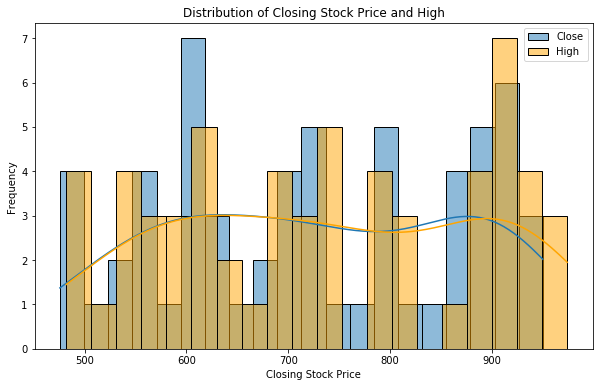

In [42]:
plt.figure(figsize=(10, 6))
sns.histplot(stock_df['Close'], kde=True, bins = 20, label = 'Close')
sns.histplot(stock_df['High'], kde=True, bins = 20, color= 'orange', label = 'High')

plt.title('Distribution of Closing Stock Price and High' )
plt.xlabel('Closing Stock Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [6]:
# Fetch options data
options_data = yf.Ticker(ticker_symbol).options


In [7]:
# Print the available options expiration dates
print("\nOptions Expiration Dates:")
print(options_data)


Options Expiration Dates:
('2024-04-05', '2024-04-12', '2024-04-19', '2024-04-26', '2024-05-03', '2024-05-10', '2024-05-17', '2024-06-21', '2024-07-19', '2024-08-16', '2024-09-20', '2024-10-18', '2024-11-15', '2024-12-20', '2025-01-17', '2025-02-21', '2025-03-21', '2025-06-20', '2025-12-19', '2026-01-16', '2026-06-18', '2026-12-18')


In [8]:
# Fetch options chain for a specific expiration date
expiration_date = options_data[7]
print(expiration_date) 
options_chain = yf.Ticker(ticker_symbol).option_chain(expiration_date)


2024-06-21


In [14]:
# Convert options chain data to DataFrames
calls_df = pd.DataFrame(options_chain.calls)
puts_df = pd.DataFrame(options_chain.puts)


In [19]:
calls_df.tail()


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
284,NVDA240621C01900000,2024-03-28 19:50:57+00:00,1900.0,2.19,2.08,2.26,-0.51,-18.888887,26,681,0.714236,False,REGULAR,USD
285,NVDA240621C01910000,2024-03-27 14:55:43+00:00,1910.0,2.70,2.05,2.20,0.00,0.000000,1,126,0.716250,False,REGULAR,USD
286,NVDA240621C01920000,2024-03-27 16:52:33+00:00,1920.0,2.55,1.98,2.15,0.00,0.000000,67,200,0.717471,False,REGULAR,USD
287,NVDA240621C01930000,2024-03-28 19:56:29+00:00,1930.0,2.02,2.00,2.10,-0.72,-26.277372,3,94,0.720828,False,REGULAR,USD
288,NVDA240621C01940000,2024-03-28 19:39:44+00:00,1940.0,1.98,1.90,1.96,-0.38,-16.101690,101,3482,0.718875,False,REGULAR,USD


In [49]:
calls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   contractSymbol     289 non-null    object             
 1   lastTradeDate      289 non-null    datetime64[ns, UTC]
 2   strike             289 non-null    float64            
 3   lastPrice          289 non-null    float64            
 4   bid                289 non-null    float64            
 5   ask                289 non-null    float64            
 6   change             289 non-null    float64            
 7   percentChange      289 non-null    float64            
 8   volume             289 non-null    int64              
 9   openInterest       289 non-null    int64              
 10  impliedVolatility  289 non-null    float64            
 11  inTheMoney         289 non-null    bool               
 12  contractSize       289 non-null    object         

In [51]:
calls_df.describe()

,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility
count,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000
mean,804.152249,290.797578,289.584118,292.458616,-2.116436,-3.086834,37.211073,1253.366782,0.896845
std,535.527768,272.477560,273.842258,275.997072,10.347284,7.738809,122.717524,3193.715541,0.738643
min,5.000000,1.980000,1.900000,1.960000,-57.700012,-53.048134,1.000000,9.000000,0.000010
25%,365.000000,27.350000,27.100000,27.500000,-1.260002,-3.885354,2.000000,216.000000,0.588253
50%,725.000000,208.150000,207.050000,209.500000,0.000000,0.000000,4.000000,631.000000,0.668155
75%,1170.000000,521.000000,517.200000,520.250000,0.000000,0.000000,20.000000,1139.000000,0.966919
max,1940.000000,941.220000,896.600000,899.650000,14.530029,12.222227,1668.000000,41860.000000,7.281007


/home/rhythm/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/rhythm/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/rhythm/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


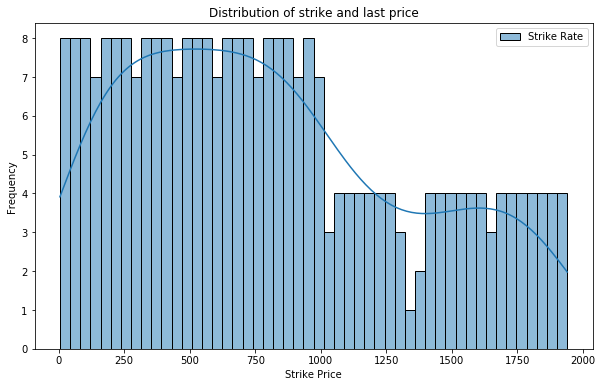

In [48]:
plt.figure(figsize=(10, 6))
sns.histplot(calls_df['strike'], kde=True, bins = 50, label = 'Strike Rate')
#sns.histplot(calls_df['lastPrice'], kde=True, bins = 20, color= 'orange', label = 'Last Price')

plt.title('Distribution of strike and last price' )
plt.xlabel('Strike Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()